Loading necessary modules

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')


home = os.path.expanduser("~")
sys.path.append(os.getcwd())
from gpym.GPM import DPR
from gpym.retrieve import OE



lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()


Loading DPR data file into the xarray object 

In [2]:
fn = '2A.GPM.DPR.V8-20180723.20170430-S063819-E081054.018010.V06A.slice.cmp.HDF5'
dpr = DPR(fn)
print(dpr.NS)

<xarray.Dataset>
Dimensions:                      (nscan: 210, nray: 49, nNode: 5, nbin: 176,
                                  nbinSZP: 7, nDSD: 2, nNUBF: 3, LS: 2,
                                  method: 6, foreBack: 2, nearFar: 2, nsdew: 3,
                                  nNP: 4, XYZ: 3)
Coordinates:
    Latitude                     (nscan, nray) float32 ...
    Longitude                    (nscan, nray) float32 ...
    time                         (nscan) datetime64[ns] 2017-04-30T07:35:23.7...
    Altitude                     (nbin) float64 21.88 21.75 21.62 ... 0.125 0.0
Dimensions without coordinates: nscan, nray, nNode, nbin, nbinSZP, nDSD, nNUBF,
                                LS, method, foreBack, nearFar, nsdew, nNP, XYZ
Data variables: (12/103)
    binBBBottom                  (nscan, nray) float32 ...
    binBBPeak                    (nscan, nray) float32 ...
    binBBTop                     (nscan, nray) float32 ...
    flagAnvil                    (nscan, nray) floa

Setting the retrieval parameters:

In [3]:
nscan = 121                # nscan - along track dimension
nrayMS = 12               # nrayMS - across track dimension in the matched swath 
make_plot = True          # a flag if some debugging plots are generated
fig_dir = home            # directory for figures
method = 'SLSQP'          # minimization method from the scipy module (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
retr_resol_ice = 0.5      # retrieval vertical resolution in ice 
retr_resol_rain = 1.5     # retrieval vertical resolution in rain
retr_resol_scale_x1 = 3.  # reduction of the retrieval resolution for the second principal component ()
maxiter = 60              # maximum number of iterations in the minimization process

We construct the retrieval algorithm by selecting the a-priori data (can be changed to 'GV_disdrometers')

In [4]:
retrieval = OE(apriori = 'GV_radars')

Ku band, |K|^2 = 0.925
Ka band, |K|^2 = 0.899


Optimization terminated successfully    (Exit mode 0)
            Current function value: 174.45801779651578
            Iterations: 32
            Function evaluations: 912
            Gradient evaluations: 32
1.8s


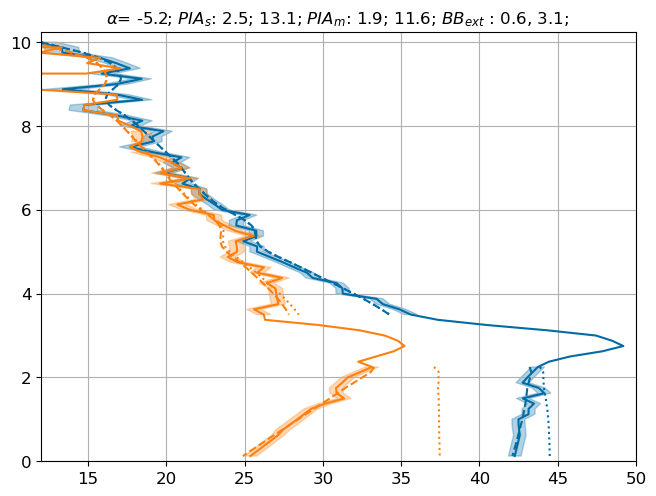

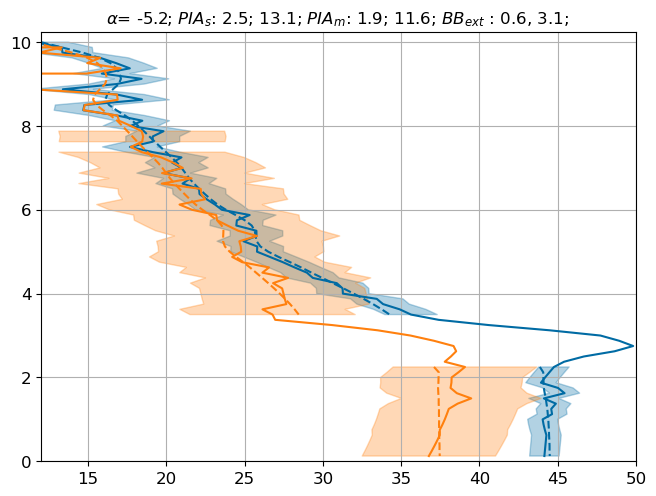

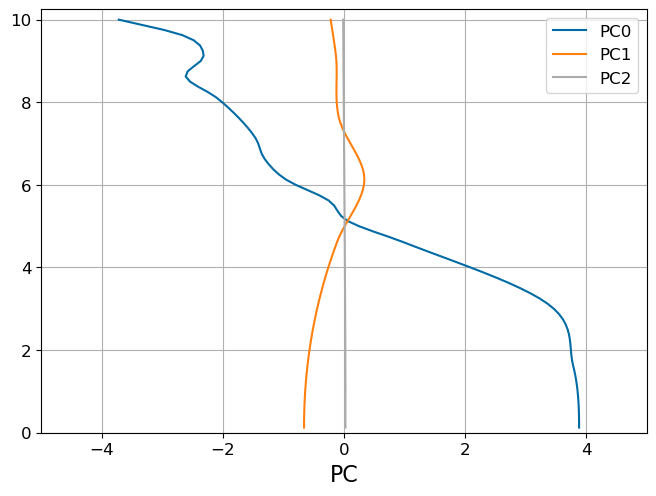

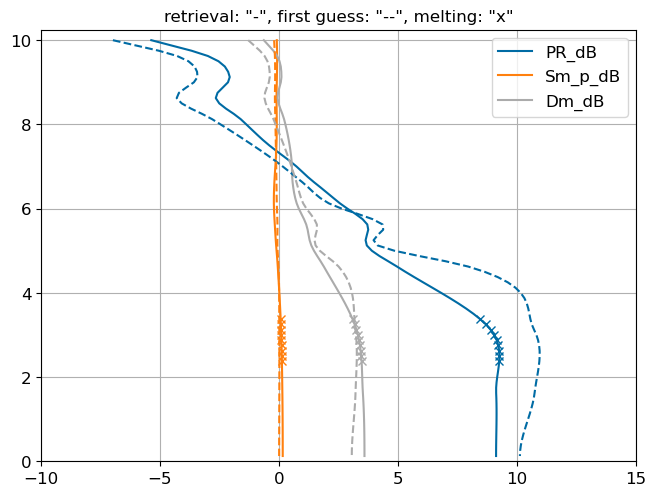

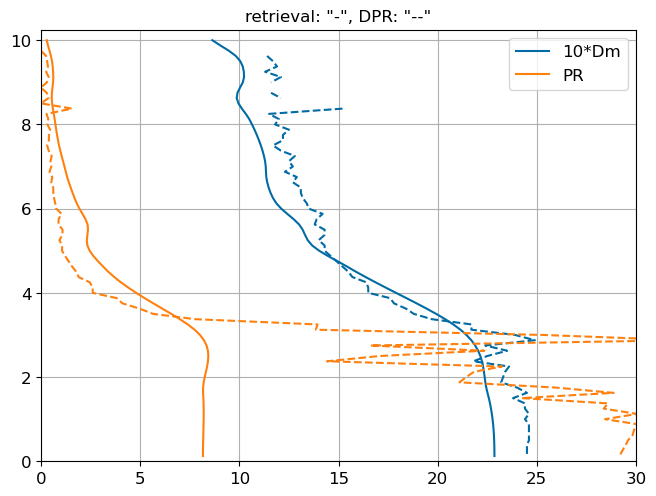

In [5]:
retrieval.retrieve_PC_1D(dpr_obj = dpr, nscan = nscan, nrayMS = nrayMS, 
                        make_plot = make_plot, fig_dir = fig_dir,                          
                        method = method, 
                        retr_resol_ice = retr_resol_ice, retr_resol_rain = retr_resol_rain, 
                        retr_resol_scale_x1 = retr_resol_scale_x1, 
                        maxiter = maxiter)

                        

We can run it in a loop. Let's iterate over different rays and scans.

In [6]:
ind_scan = dpr.NS.nscan.values    # we select all scans along the track
ind_ray = range(16,17)            # only ray 16 is selected 

For loop we avoid plotting

In [7]:

for ii in ind_scan:
   
    for rr in ind_ray:
        print ('{}, {}'.format(ii,rr))
        try:       
            if dpr['MS'].flagPrecip[ii,nrayMS] !=11.: continue # only run if precipiatation is detected at both frequencies

            retrieval.retrieve_PC_1D(dpr_obj = dpr, nscan = ii, nrayMS = rr, 
                        make_plot = False, fig_dir = fig_dir,    
                        method = method, 
                        retr_resol_ice = retr_resol_ice, retr_resol_rain = retr_resol_rain, 
                        retr_resol_scale_x1 = retr_resol_scale_x1, 
                        maxiter = maxiter)              
        except Exception as ex:
            print(ex)


0, 16
1, 16
2, 16
3, 16
delta PIA unreliable
index -1 is out of bounds for axis 0 with size 0
4, 16
index -1 is out of bounds for axis 0 with size 0
5, 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 113.55145559023612
            Iterations: 16
            Function evaluations: 261
            Gradient evaluations: 16
0.5s
6, 16
index -1 is out of bounds for axis 0 with size 0
7, 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 156.7950536999872
            Iterations: 16
            Function evaluations: 227
            Gradient evaluations: 16
0.5s
8, 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.7292966391999
            Iterations: 14
            Function evaluations: 186
            Gradient evaluations: 14
0.4s
9, 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 136.85306914534814
            Itera

saving the output variables

In [8]:
dset_out = dpr['MS'][['PR_dB', 'Sm_dB', 'Dm_dB', 
               'zKuSim', 'zKaSim', 'zKuEffSim', 'zKaEffSim',
               'Alpha_dB', 'piaKuSim',  'piaKaSim', 
                              'piaKaBB' , 'piaKuBB', 'CF_n']]
                             
dset_out['Sm_p_dB'] = retrieval._transform_Sm_dB_Dm_dB_2_Sm_p_dB(dset_out['Sm_dB'],  
                        dset_out['Dm_dB'])

encoding =  {key: {'zlib': True, 'complevel': 6,
        '_FillValue': -999.,} for key in dset_out.variables.keys()}

PR_dB: 10 log10 of precipitation rate in mm/h;
Sm_dB: 10 log10 of the DSD width, i.e, mass-weighted standard deviation of D (DSD is paramatrized in terms of melted equivalent diameter)[mm];
Dm_dB: 10 log10 of the mass-weighted mean (melted-equivalent) dimater [mm] ;
zKuSim, zKaSim: simulated attenuated reflectivity at Ku and Ka [dBZ];
zKuEffSim, zKaEffSim: simulated effective reflectivity [dBZ]; 
piaKaBB, piaKuBB: bright band extinction [dB];

In [9]:
dset_out_name =  fn.replace('.HDF5', '.nc')
dset_out.to_netcdf(dset_out_name, engine = 'h5netcdf',encoding =  encoding) # saving to a file  

Let's generate some figures, we select just a subset of the 3-dim data

In [10]:
nrayMS = 16

loc_MNS = dpr.MNS.isel(nscan = ind_scan)
loc_MNS = loc_MNS.where(loc_MNS.zFactorMeasured>10)

loc_MS = dpr['MS'].isel(nscan = ind_scan)
loc_MS = loc_MS.where(loc_MNS.zFactorMeasured>15)

Plots:

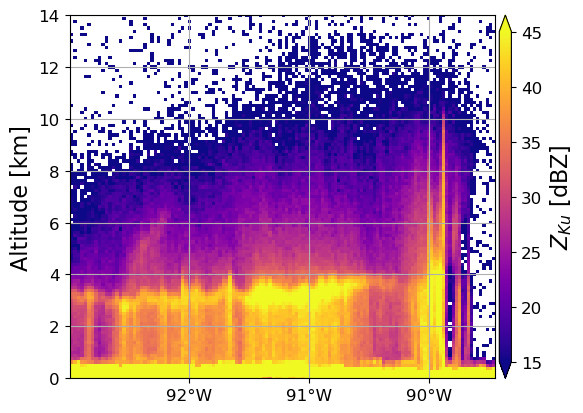

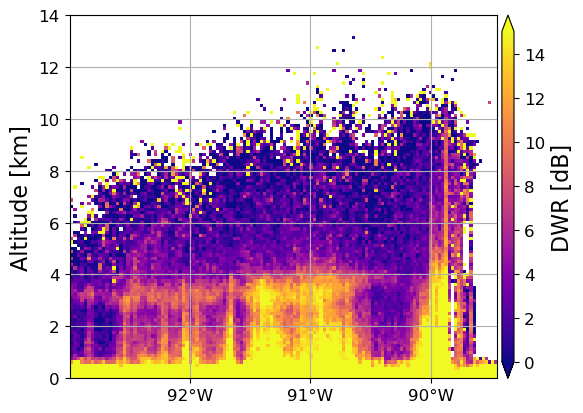

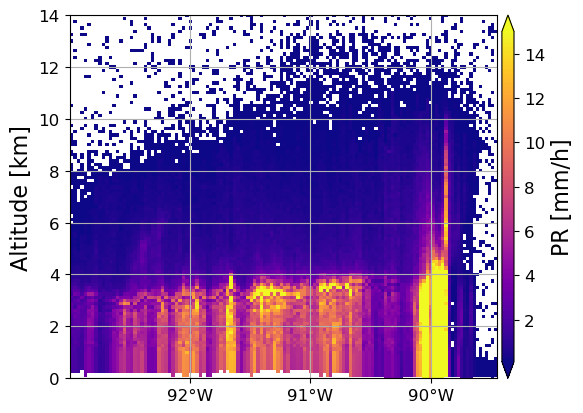

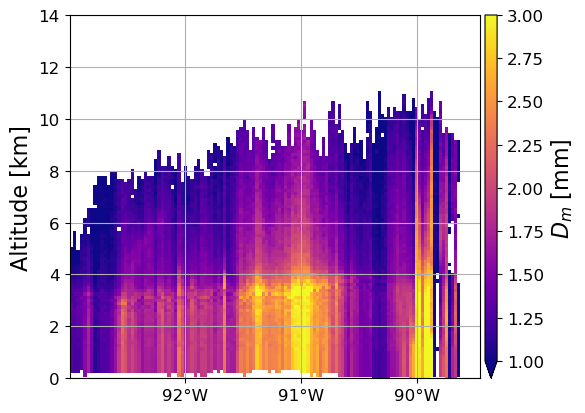

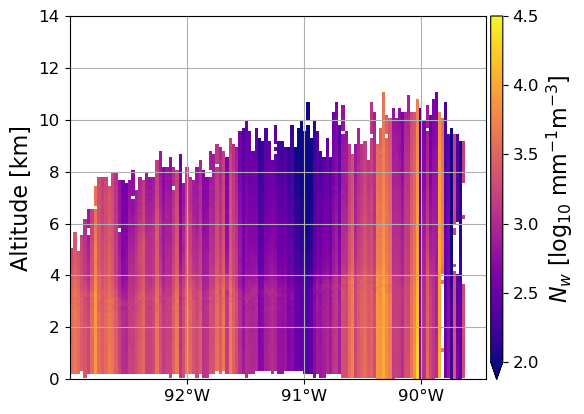

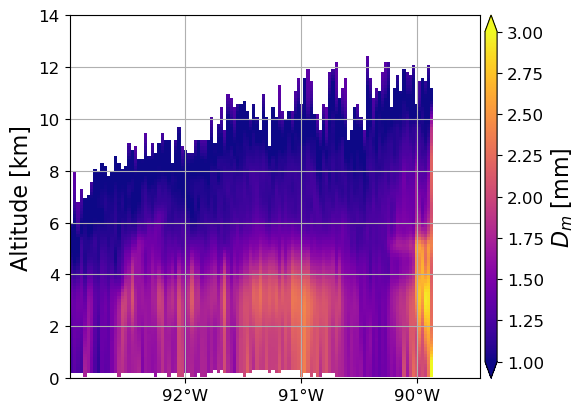

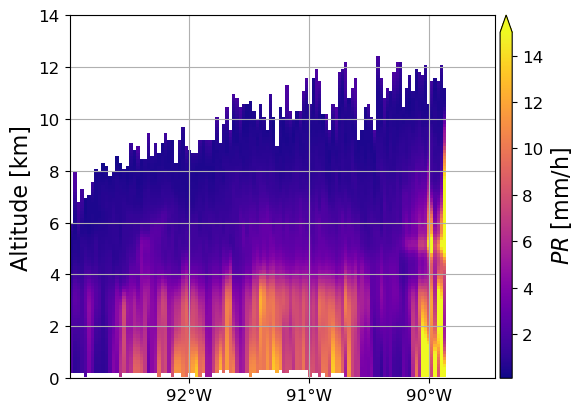

In [11]:
fn_out = os.path.join(fig_dir, fn.replace('.HDF5', '.Zku.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
loc_MNS.zFactorMeasured.isel(nrayMS = nrayMS).plot(
    x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 15, vmax = 45., ax = ax,
    cbar_kwargs= {'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 
        'label': '$Z_{Ku}$ [dBZ]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
fig.savefig(fn_out, dpi =200)



fn_out = os.path.join(fig_dir, fn.replace('.HDF5',  '.DWR.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
(loc_MNS.zFactorMeasured-loc_MS.zFactorMeasured).isel(
    nrayMS = nrayMS).plot( x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 0, vmax = 15., ax = ax,
    cbar_kwargs = {'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': 'DWR [dB]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)




fn_out = os.path.join(fig_dir, fn.replace('.HDF5', '.precipRate.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
loc_MNS.precipRate.isel(nrayMS = nrayMS).plot(
    x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 0.1, vmax = 15., ax = ax,
    cbar_kwargs = {'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': 'PR [mm/h]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)



fn_out = os.path.join(fig_dir, fn.replace('.HDF5',  '.Dm.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
(loc_MNS.paramDSD).isel(nDSD = 1,
    nrayMS = nrayMS).plot( x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 1., vmax = 3., ax = ax,
    cbar_kwargs = {'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': '$D_m$ [mm]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)

fn_out = os.path.join(fig_dir, fn.replace('.HDF5',  '.Nw.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
(loc_MNS.paramDSD/10).isel(nDSD = 0,
    nrayMS = nrayMS).plot( x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 2., vmax = 4.5, ax = ax,
    cbar_kwargs = {'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': '$N_w$ [log$_{10}$ mm$^{-1}$m$^{-3}$]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)




fn_out = os.path.join(fig_dir, fn.replace('.HDF5', '.OE_Dm.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
(10**(dpr['MS'].Dm_dB.where(dpr['MS'].Dm_dB>-90.).isel(nrayMS = nrayMS, nscan = ind_scan)/10)).plot(
    x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 1., vmax = 3., ax = ax,
    cbar_kwargs={'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': '$D_m$ [mm]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)


fn_out = os.path.join(fig_dir, fn.replace('.HDF5', '.OE_PR.png') )
fig ,ax = plt.subplots(figsize = (6,4.3))
(10**(dpr['MS'].PR_dB.where(dpr['MS'].PR_dB>-90.).isel(
    nrayMS = nrayMS, nscan = ind_scan)/10)).plot(
    x = 'Longitude', y = 'Altitude', 
    cmap = 'plasma', vmin = 0.1, vmax = 15., ax = ax,
    cbar_kwargs={'fraction': 0.1, 'aspect': 30, 'pad': 0.01, 'label': '$PR$ [mm/h]'})
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlabel('')
ax.set_xlim(-93., -89.45)
ax.set_xticks([-92, -91, -90])
ax.set_ylim(0,14)
ax.grid()
fig.tight_layout()
plt.savefig(fn_out, dpi =200)     